# Link Prediction in NetworKit

## Setup

In [13]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random
from cython import *

In [14]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


In [15]:
def drawROC(indexName, predictions):
    X, Y = roc.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.plot([0, 1], [0, 1], ls='--')
    plt.legend(handles=[curve], loc=4)
def drawPR(indexName, predictions):
    X, Y = pr.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.legend(handles=[curve])
def drawROCs(supTitle, **args):
    predictions = args["predictions"]
    indexNames = args["indexNames"]
    plt.suptitle(supTitle, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    plt.plot([0, 1], [0, 1], '#aaaaaa', ls='--')
    handles = []
    for i in range(0, len(indexNames)):
        X, Y = roc.getCurve(predictions[i])
        curve, = plt.plot(X, Y, label=indexNames[i])
        handles.append(curve)
    plt.legend(handles=handles, loc=4, fontsize=10)

## Choose graph

In [16]:
#testGraph, trainingGraph = linkprediction.readGraph("input/out.facebook-wosn-links", 0.3)
testGraph = readGraph("input/CA-CondMat_tab-sep.edgelist", Format.EdgeListTabOne)

## Create training and test set

In [17]:
trainingGraph = linkprediction.TrainingGraphSampler.byPercentage(testGraph, 0.7)
print("Train / Test =", trainingGraph.numberOfEdges(), "/", testGraph.numberOfEdges())

Train / Test = 65447 / 93497


In [18]:
#tmp = linkprediction.TrainingGraphSampler.byPercentage(trainingGraph, 0.7)
#supervisedTrainingNodePairs = linkprediction.MissingLinksFinder(tmp).findAll(2)
nodePairsTest = linkprediction.MissingLinksFinder(trainingGraph).findAll(2)
print("Found", len(testNodePairs), "missing links")

Found 771363 missing links


## Create link predictor instances

In [19]:
katzIndex = linkprediction.KatzIndex(trainingGraph, 5, 0.005)
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(trainingGraph)
jaccardIndex = linkprediction.JaccardIndex(trainingGraph)
preferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(trainingGraph)
adamicAdarIndex = linkprediction.AdamicAdarIndex(trainingGraph)
uDegreeIndex = linkprediction.UDegreeIndex(trainingGraph)
vDegreeIndex = linkprediction.VDegreeIndex(trainingGraph)
algebraicDistanceIndex = linkprediction.AlgebraicDistanceIndex(trainingGraph, 5, 10)
algebraicDistanceIndex.preprocess()
neighborhoodDistanceIndex = linkprediction.NeighborhoodDistanceIndex(trainingGraph)
totalNeighborsIndex = linkprediction.TotalNeighborsIndex(trainingGraph)
neighborsMeasureIndex = linkprediction.NeighborsMeasureIndex(trainingGraph)
sameCommunityIndex = linkprediction.SameCommunityIndex(trainingGraph)
adjustedRandIndex = linkprediction.AdjustedRandIndex(trainingGraph)
resourceAllocationIndex = linkprediction.ResourceAllocationIndex(trainingGraph)

# Supervised Link Prediction

## Choose link predictors to use as feature-generators

In [41]:
linkPredictors = (commonNeighborsIndex, jaccardIndex, adamicAdarIndex, preferentialAttachmentIndex, uDegreeIndex, vDegreeIndex, algebraicDistanceIndex, neighborhoodDistanceIndex, totalNeighborsIndex, neighborsMeasureIndex, sameCommunityIndex, resourceAllocationIndex)

## Create training set with negative instances

To train a classifier there has to be a specific training set with positive (link) and negative instances (absent link) which is mostly balanced.
To create this set we randomly pick a given number of positive instances from the trainingGraph. Then we randomly pick the same number of negative instances from the trainingGraph excluding


WARNING: Right now we generate a training set from edges in the test set! Fix this!

In [67]:
tmp = linkprediction.TrainingGraphSampler.byPercentage(trainingGraph, 0.9)
nodePairsTrain = linkprediction.MissingLinksFinder(tmp).findAll(2)

classesTrain = linkprediction.getClasses(nodePairsTrain, testGraph)
#samplesTrain = linkprediction.getSamples(nodePairsTrain, *linkPredictors)

classesTest = linkprediction.getClasses(nodePairsTest, testGraph)
samplesTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)
print("#all:", len(nodePairsTrain), "#positives:", sum(classesTrain))

#all: 696177 #positives: 18455


## Evaluation

In [68]:
roc = linkprediction.ROCMetric(testGraph)
pr = linkprediction.PrecisionRecallMetric(testGraph)

In [69]:
dtc = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5, max_features=0.5)
#dtc = ensemble.AdaBoostClassifier()
#dtc = tree.DecisionTreeClassifier()
linkprediction.trainClassifier(nodePairsTrain, testGraph, dtc, *linkPredictors)

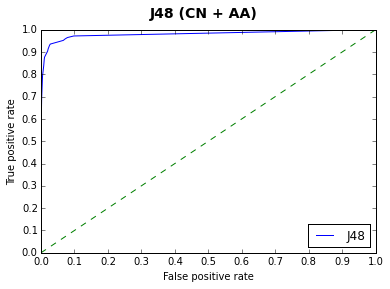

In [70]:
predictionsKNN = dtc.predict_proba(samplesTest)
isEdgePred = [x[1] for x in predictionsKNN]
#sum = 0
#for i in range(0, len(predictionsKNN)):
#    if predictionsKNN[i] == classesTest[i]:
#        sum +=1
#sum
fpr, tpr, thresholds = metrics.roc_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(fpr, tpr, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [71]:
metrics.roc_auc_score(classesTest, isEdgePred)

0.97960247493424879

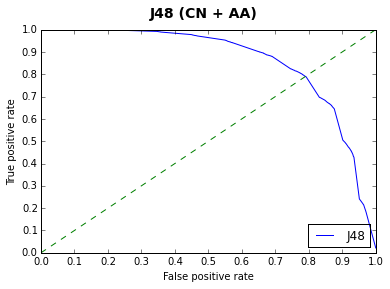

In [72]:
precision, recall, thresholds = metrics.precision_recall_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(recall, precision, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [73]:
pr.getAreaUnderCurve((recall, precision))

0.8597940108525494

In [74]:
startTime = time.time()
predictions = commonNeighborsIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.7482495307922363 seconds


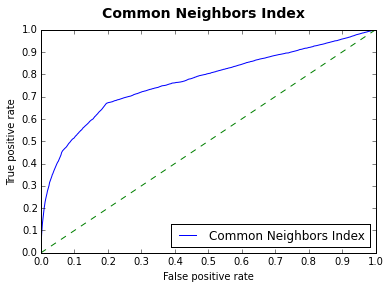

In [75]:
drawROC("Common Neighbors Index", predictions)

In [76]:
roc.getAreaUnderCurve()

0.7699755063383179

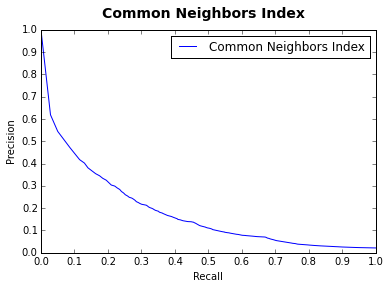

In [77]:
drawPR("Common Neighbors Index", predictions)

In [78]:
pr.getAreaUnderCurve()

0.18261268607197356

In [79]:
startTime = time.time()
predictions = jaccardIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

1.0685386657714844 seconds


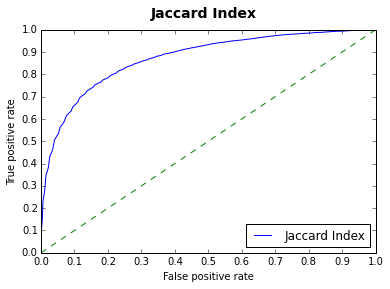

In [80]:
drawROC("Jaccard Index", predictions)

In [81]:
roc.getAreaUnderCurve()

0.8720644731456958

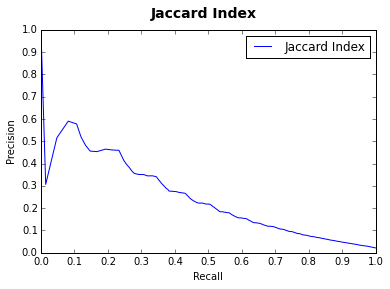

In [82]:
drawPR("Jaccard Index", predictions)

In [83]:
pr.getAreaUnderCurve()

0.2489592491489418

In [84]:
startTime = time.time()
predictions = preferentialAttachmentIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.51784348487854 seconds


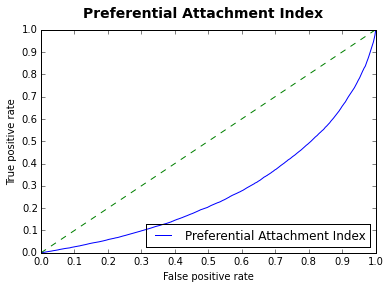

In [85]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [86]:
roc.getAreaUnderCurve()

0.27815045822789025

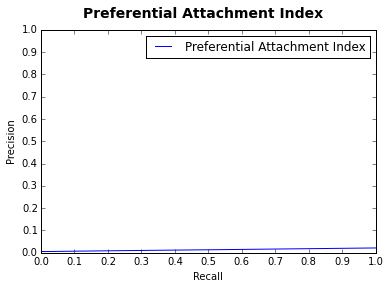

In [87]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.legend(handles=[curve])

In [88]:
pr.getAreaUnderCurve()

0.013843214220796

In [89]:
startTime = time.time()
predictions = adamicAdarIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.7818264961242676 seconds


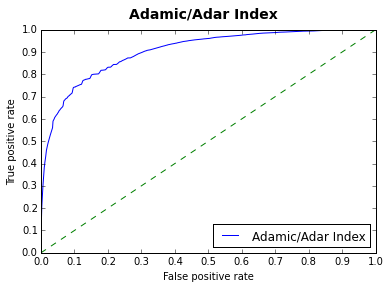

In [90]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [91]:
roc.getAreaUnderCurve()

0.9039934700573318

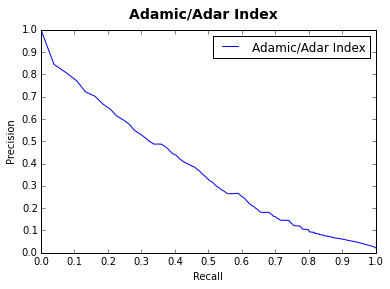

In [92]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.legend(handles=[curve])

In [93]:
pr.getAreaUnderCurve()

0.3758077293054993

In [94]:
startTime = time.time()
predictions = uDegreeIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.5337800979614258 seconds


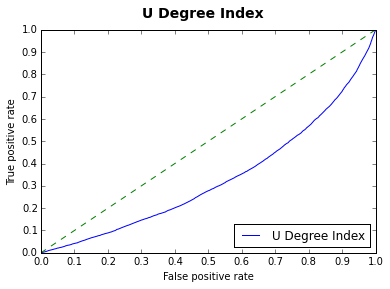

In [95]:
X, Y = roc.getCurve(predictions)
plt.suptitle("U Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="U Degree Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [96]:
roc.getAreaUnderCurve()

0.332376245512464

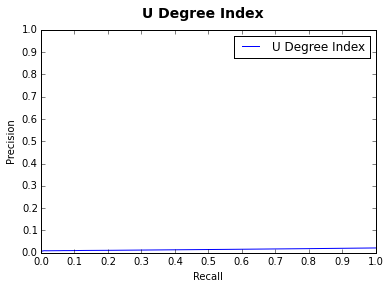

In [97]:
X, Y = pr.getCurve(predictions)
plt.suptitle("U Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="U Degree Index")
plt.legend(handles=[curve])

In [98]:
pr.getAreaUnderCurve()

0.015058614857119209

In [99]:
startTime = time.time()
predictions = vDegreeIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.40902161598205566 seconds


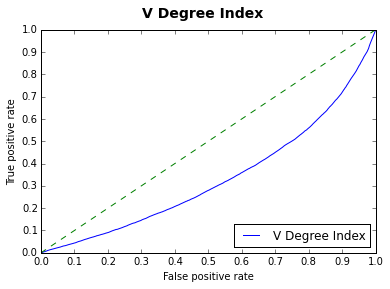

In [100]:
X, Y = roc.getCurve(predictions)
plt.suptitle("V Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="V Degree Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [101]:
roc.getAreaUnderCurve()

0.33317028358596185

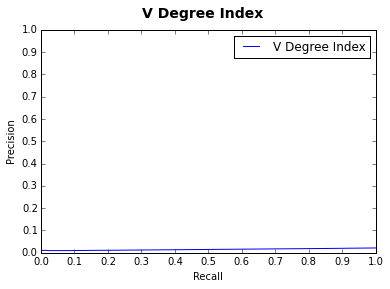

In [102]:
X, Y = pr.getCurve(predictions)
plt.suptitle("V Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="V Degree Index")
plt.legend(handles=[curve])

In [103]:
pr.getAreaUnderCurve()

0.015203983545069055

In [104]:
startTime = time.time()
algebraicDistanceIndex.preprocess()
predictions = algebraicDistanceIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.5596048831939697 seconds


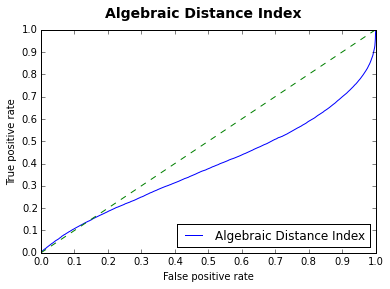

In [105]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Algebraic Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Algebraic Distance Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [106]:
roc.getAreaUnderCurve()

0.39056421667763813

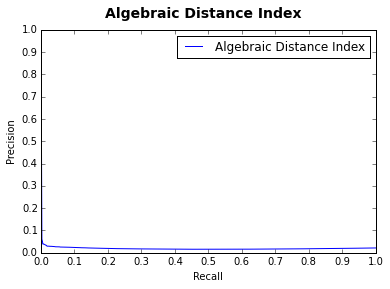

In [107]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Algebraic Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Algebraic Distance Index")
plt.legend(handles=[curve])

In [108]:
pr.getAreaUnderCurve()

0.020463743908464966

In [109]:
startTime = time.time()
predictions = neighborhoodDistanceIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.7128252983093262 seconds


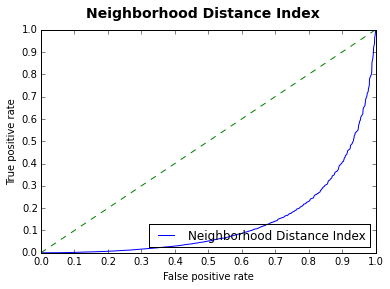

In [110]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Neighborhood Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighborhood Distance Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [111]:
roc.getAreaUnderCurve()

0.13634250149965998

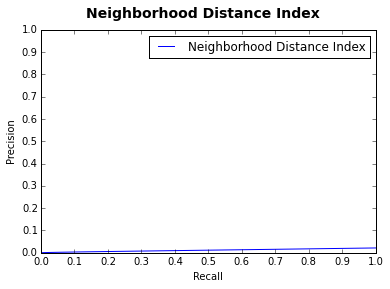

In [112]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Neighborhood Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighborhood Distance Index")
plt.legend(handles=[curve])

In [113]:
pr.getAreaUnderCurve()

0.011681610437332223

In [114]:
#node = trainingGraph.randomNode()
#nodes = trainingGraph.neighbors(node)
#subGraph = graph.Subgraph().fromNodes(trainingGraph, nodes)

In [115]:
#LIST_LENGTH = len(nodes) - 1
#a = []
#color = {}
#while len(a) < LIST_LENGTH:
#    a.append(500)
#for e in nodes:
#    color[e] = len(nodes)
#a.append(2000)
#len(color)
#color[list(color)[-1]] = len(nodes) / 2
#color[list(color)[-2]] = len(nodes) / 3

In [116]:
#viztasks.drawGraph(subGraph, (7,7), False, a, None, color)

In [117]:
startTime = time.time()
predictions = katzIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

86.38394141197205 seconds


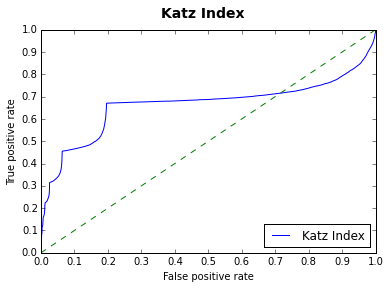

In [118]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [119]:
roc.getAreaUnderCurve()

0.6622743060544823

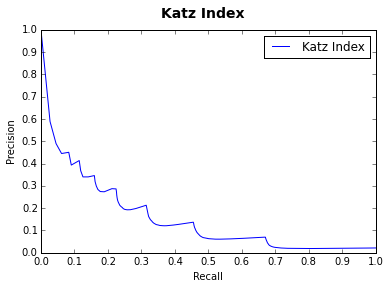

In [120]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.legend(handles=[curve])

In [121]:
pr.getAreaUnderCurve()

0.15425984622420533

In [122]:
startTime = time.time()
predictions = totalNeighborsIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.769277811050415 seconds


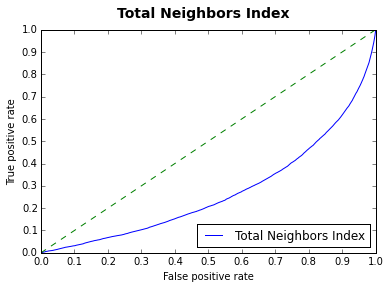

In [123]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Total Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Total Neighbors Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [124]:
roc.getAreaUnderCurve()

0.2710342160393798

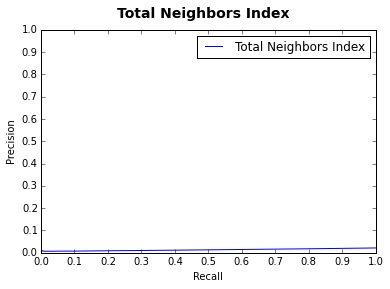

In [125]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Total Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Total Neighbors Index")
plt.legend(handles=[curve])

In [126]:
pr.getAreaUnderCurve()

0.01352633116789549

In [127]:
startTime = time.time()
predictions = neighborsMeasureIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

3.467824697494507 seconds


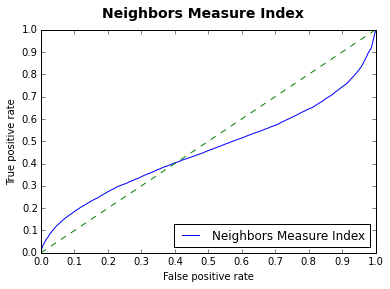

In [128]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Neighbors Measure Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighbors Measure Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [129]:
roc.getAreaUnderCurve()

0.4620405263838273

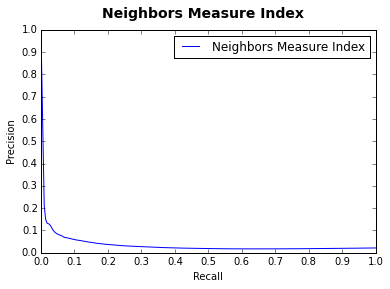

In [130]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Neighbors Measure Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighbors Measure Index")
plt.legend(handles=[curve])

In [131]:
pr.getAreaUnderCurve()

0.035919755843004005

In [132]:
startTime = time.time()
predictions = adjustedRandIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

202.3646535873413 seconds


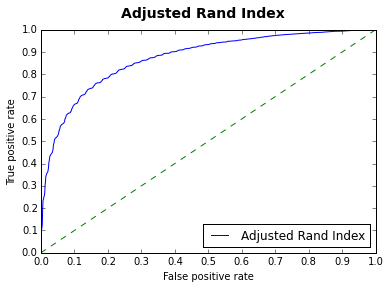

In [133]:
drawROC("Adjusted Rand Index", predictions)

In [134]:
roc.getAreaUnderCurve()

0.8725427565380884

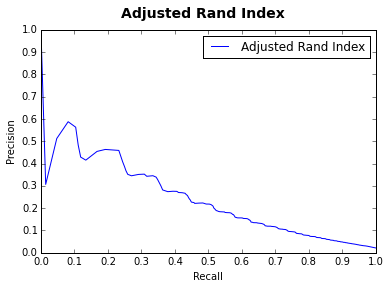

In [135]:
drawPR("Adjusted Rand Index", predictions)

In [136]:
pr.getAreaUnderCurve()

0.24401386643359188

In [21]:
startTime = time.time()
predictions = resourceAllocationIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.7658529281616211 seconds


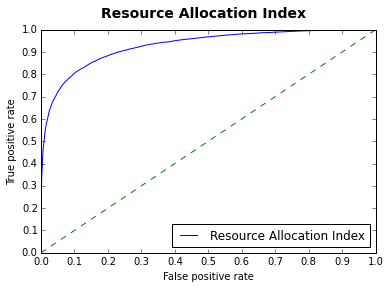

In [22]:
drawROC("Resource Allocation Index", predictions)

In [23]:
roc.getAreaUnderCurve()

0.9280528151010892

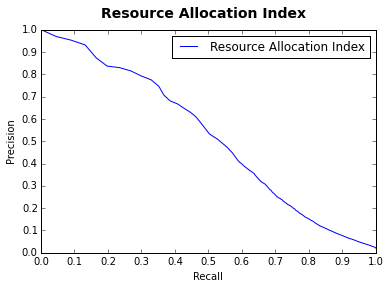

In [24]:
drawPR("Resource Allocation Index", predictions)

In [25]:
pr.getAreaUnderCurve()

0.521405639253595

In [ ]:
p1 = katzIndex.runOnParallel(nodePairsTest)
p2 = commonNeighborsIndex.runOnParallel(nodePairsTest)
p3 = jaccardIndex.runOnParallel(nodePairsTest)
p4 = preferentialAttachmentIndex.runOnParallel(nodePairsTest)
p5 = adamicAdarIndex.runOnParallel(nodePairsTest)
p6 = algebraicDistanceIndex.runOnParallel(nodePairsTest)
p7 = neighborhoodDistanceIndex.runOnParallel(nodePairsTest)
p8 = neighborsMeasureIndex.runOnParallel(nodePairsTest)
ins=["Katz", "Common Neighbors", "Jaccard", "Preferential Attachment", "Adamic/Adar", "Algebraic Distance", "Neighborhood Distance", "Neighbors-Measure"]
preds=[p1, p2, p3, p4, p5, p6, p7, p8]
drawROCs("Polblogs", indexNames=ins, predictions=preds)